In [1]:
import json
import numpy as np
from collections import defaultdict
from scipy.sparse import csr_matrix

In [2]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                        shape=loader['shape'])

In [3]:
with open('transmute_data.json') as f:
    data = json.load(f)
with open('sigma.json') as f:
    sigma = json.load(f)
with open('fission_products.json') as f:
    fission_products = json.load(f)

In [4]:
nuc_idx = {n: i for i, n in enumerate(data['nucs'])}
N = len(nuc_idx)
nuc_set = set(data['nucs'])

In [5]:
decay_consts = {}
gammas = {}
for key, val in data['symbols'].items():
    if key.startswith('lambda'):
        _, n = key.split('_')
        decay_consts[n] = val
    elif key.startswith('gamma'):
        _, i, j, *_ = key.split('_')
        gammas[i, j] = val
    else:
        raise KeyError

In [6]:
def fix_gammas(gammas):
    """
    Make sure the gammas sum to 1. If there is a descrepancy, offset the biggest gamma
    """
    new_gammas = gammas.copy()
    for nuc in nuc_idx:
        gamma_sum = sum(gammas[(i, j)] for i, j in gammas if i == nuc)
        if gamma_sum in [0, 1]:
            continue
        print('gamma sum for', nuc, 'is', gamma_sum)
        biggest_gamma = max([(i, j) for i, j in gammas if i == nuc], key=lambda t: gammas[t])
        print("Offsetting biggest gamma", biggest_gamma, gammas[biggest_gamma], 'by', 1-gamma_sum)
        new_gammas[biggest_gamma] = gammas[biggest_gamma] + 1 - gamma_sum
        
    for nuc in nuc_idx:
        gamma_sum = sum(new_gammas[(i, j)] for i, j in gammas if i == nuc)
        assert gamma_sum in [0, 1], (nuc, gamma_sum)

    return new_gammas

In [7]:
gammas = fix_gammas(gammas)

gamma sum for Ba133M is 1.00001
Offsetting biggest gamma ('Ba133M', 'Ba133') 0.9999 by -1.0000000000065512e-05
gamma sum for Zr89 is 1.000012
Offsetting biggest gamma ('Zr89', 'Y89M') 0.9984 by -1.1999999999900979e-05
gamma sum for Am240 is 1.0000019
Offsetting biggest gamma ('Am240', 'Pu240') 1.0 by -1.8999999999991246e-06
gamma sum for Pu237 is 1.000033
Offsetting biggest gamma ('Pu237', 'Np237') 1.0 by -3.2999999999949736e-05
gamma sum for U231 is 1.000055
Offsetting biggest gamma ('U231', 'Pa231') 1.0 by -5.499999999991623e-05


In [8]:
sigma_ij = {(i, j): v for v, i, j in sigma.values() if v > 0.0 and j is not None}

In [9]:
phi = 4e14 * 1e-24  # flux, n / barn /s

In [10]:
dok = defaultdict(float) # indexed b y nuclide name
# let's first add the cross section channels
for i, j in sigma_ij:
    v = sigma_ij.get((i, j), 0.0) * phi
    dok[i, j] += v
    dok[i, i] -= v
# now let's add the fission products
for i, yields in fission_products.items():
    v = sigma.get('sigma_fission_' + i, [0.0])[0] * phi
    dok[i, i] -= v
    for j, fpy in yields.items():
        dok[i, j] += v*fpy
    assert set(yields.keys()) <= nuc_set
# now let's add the decay consts
for (i, j), g in gammas.items():
    dok[i, j] += g * decay_consts[i]
for i, v in decay_consts.items():
    dok[i, i] -= v

In [11]:
len(dok)

9671

In [12]:
rows = []
cols = []
vals = []
for (i, j), v in dok.items():
    if (v == 0.0) or (i not in nuc_idx) or (j not in nuc_idx):
        continue
    rows.append(nuc_idx[i])
    cols.append(nuc_idx[j])
    vals.append(v)

In [13]:
mat = csr_matrix((vals, (rows, cols)), shape=(N, N))

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

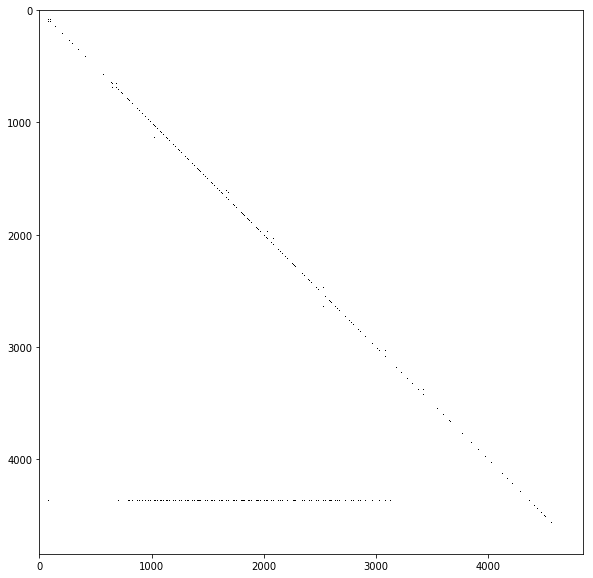

In [15]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(mat.toarray() == 0.0, interpolation='none', cmap='gray')

In [16]:
save_sparse_csr('transmute.npz', mat)

In [17]:
lmat = load_sparse_csr('transmute.npz')

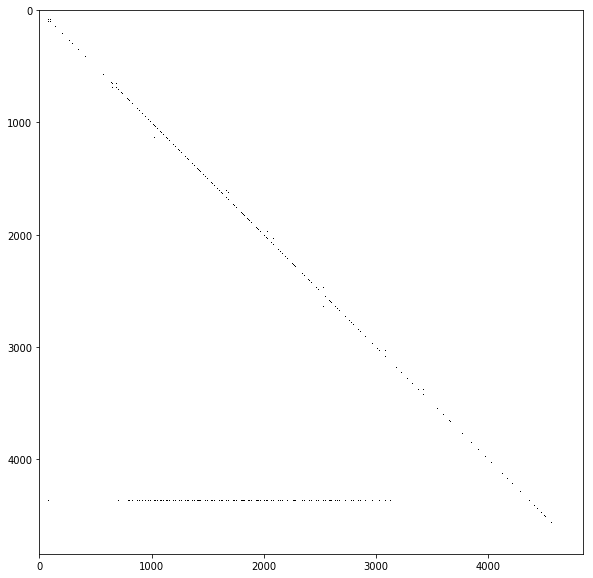

In [18]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(lmat.toarray() == 0.0, interpolation='none', cmap='gray')

In [19]:
[i for i in nuc_idx if nuc_idx[i] == 10]

['He2M']

In [20]:
decay_consts['He4']

0.0

In [21]:
[i for i in sigma_ij if 'He4' in i]

[('He3', 'He4')]

In [22]:
sigma_ij[('He3', 'He4')]

59.99

In [23]:
[i for i in nuc_idx if nuc_idx[i] == 868]

['Ga70M']

In [24]:
365.25/12 * 24 * 60 * 60

2629800.0

In [25]:
2.6e6

2600000.0

In [26]:
[i for i in nuc_idx if nuc_idx[i] == 1387]

['Zr110']

In [27]:
nuc_idx['Rh117']

1690

In [28]:
nuc_idx['Ru117']

1628

In [29]:
nuc_idx['Tc117']

1569

In [30]:
nuc_idx['Cf252']

4562

In [31]:
nuc_idx['Mo117']

1513

In [32]:
[i for i in nuc_idx if nuc_idx[i] == 1594]

['Ru100']

In [33]:
nuc_idx['Pd118']

1749

In [34]:
[i for i in sigma_ij if 'Sn117' in i]

[('Sn117', 'Sn118'),
 ('Sn116', 'Sn117'),
 ('Sn117', 'In117'),
 ('Sn117', 'Cd114')]

In [35]:
[(i, sigma[i]) for i in sigma if 'Ho166' in sigma[i]]

[('sigma_alpha_Tm169', [7.809e-07, 'Tm169', 'Ho166'])]

In [36]:
nuc_idx['Co59M']

691

In [37]:
nuc_idx['H1']

0

In [38]:
np.log(2)/decay_consts['U231']

362900.0

In [39]:
[(i, sigma[i]) for i in sigma if "Ir180" in i]

[]

In [40]:
[i for i in sigma_ij if 'Ir180' in i]

[]

In [41]:
[(i, gammas[i]) for i in gammas if 'Zr89' in i]

[(('Zr89', 'Y89'), 0.001612), (('Zr89', 'Y89M'), 0.998388)]

In [42]:
np.log(2)/decay_consts['Cd117']/60/60

2.6000000000000001

In [43]:
data['nucs'][4362]

'U231'

In [44]:
for f in data['channels']:
    for type in data['channels'][f]:
        t = data['channels'][f][type]
        assert "sigma_" + type + "_" + t in sigma, (type, f)

AssertionError: ('z_3n', 'Pd118')

In [ ]:
sigma['sigma_alpha_Ir180']

In [ ]:
data['channels']["Ir180"]

In [ ]:
np.exp(-0.77*phi*2.6e6)

In [ ]:
phi

In [ ]:
for i in sorted([(sum(v for (i, j), v in gammas.items() if i == f), f) for f in nuc_idx]):
    print(i)

In [ ]:
dok[689,691]

In [ ]:
for i in sorted([(sum(gammas[(i, j)] for i, j in gammas if i == nuc), nuc) for nuc in nuc_idx]):
    print(i)

In [ ]:
data['nucs'][4337]